In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from parseData import readHeroes
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms

/usr/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [3]:
def plotHeroUsage(Y,N):
    heroes = Y['hero_picked'].unique()
    counts = []
    for hero in heroes:
        counts.append(len(Y[Y['hero_picked'] == hero]))
    counts = np.array(counts)
    heroes = heroes[counts.argsort()[-N:]]
    counts = counts[counts.argsort()[-N:]]
    print(counts[-1]/len(Y))
    y_pos = np.arange(len(heroes))
    plt.bar(y_pos,counts, align='center', alpha=0.5)
    plt.xticks(y_pos,heroes)
    plt.ylabel('counts')
    plt.title(player_id+ ' Hero usage')
    plt.savefig('plots/'+player_id+'_hero_use.png')
    plt.show()

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
def toHeroID(Y):
    hero_ids = []
    for y in Y:
        if np.argwhere(y==1).size <= 0:
            hero_ids.append(0)
        else:
            hero_ids.append(np.argwhere(y==1)[0][0] +1)
    return np.array(hero_ids) 

In [29]:
player_id = '87278757'

# player_id = '34505203'
# player_id = '82262664'
# player_id = '106863163'
data = pd.read_csv('csvs/'+player_id+'_2_simpleRep_all_X.csv')
Y = pd.read_csv('csvs/'+player_id+'_2_simpleRep_all_Y.csv')
skip_ban = False
if ('banned_hero1'not in data.columns):
    skip_ban = True
heroes =  readHeroes()
num_heroes = int(list(heroes.keys())[-1])
data =  data.dropna(1,'all')

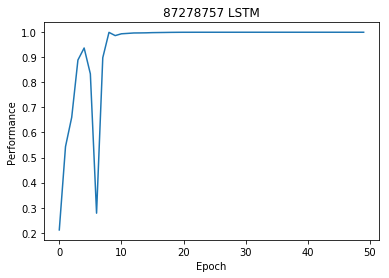

In [40]:
player_id = '87278757'
data_87 = [0.2117318788031655,0.5432470494267008,0.6602242750995786,0.8881199356811804,0.9359649399375729,0.8331336507235867,0.2783785772088575,0.8972317684522496,0.9981608180681233,0.985291799350506,0.9924803733013842,0.9940673245683177,0.995748862334605,0.9959590545553909,0.9963689293859235,0.9971203665752331,0.9974671837395298,0.9978034912927872,0.9981818372902019,0.9984130487330664,0.9985654380931361,0.9985654380931361,0.998628495759372,0.998628495759372,0.998628495759372,0.998628495759372,0.998628495759372,0.998628495759372,0.998628495759372,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898,0.9986600245924898]
y_pos = np.arange(len(data_87))
plt.plot(y_pos,data_87)
plt.ylabel('Performance')
plt.xlabel('Epoch')
plt.title(player_id +' LSTM' )
plt.savefig('plots/'+player_id +'_lstm.png' )

[1009, 315, 47, 61, 6, 7, 1, 1]


Text(0.5,1,'87278757 Hero usage')

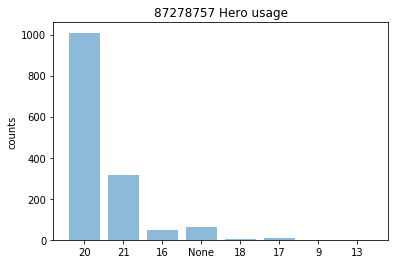

In [30]:
version_types = data['version'].drop_duplicates()
version_counts = []
for version in version_types:
    version_counts.append(len(data[data['version'] == version]))
print(version_counts)
y_pos = np.arange(len(version_types))
plt.bar(y_pos,version_counts, align='center', alpha=0.5)
plt.xticks(y_pos,version_types)
plt.ylabel('counts')
plt.savefig('plots/'+player_id+'_versions_played.png')
plt.title(player_id+ ' Hero usage')

In [14]:
X = data.drop(columns=['match_id','version','start_time'])
X = X.fillna(0)
allies = np.zeros((X.shape[0],num_heroes))
enemies = np.zeros((X.shape[0],num_heroes))
if not skip_ban:
    banned = np.zeros((X.shape[0],num_heroes))
output = np.zeros((Y.shape[0],num_heroes))
for i,row in X.iterrows():
    allies[i,int(row['ally_hero1'])-1] = 1
    allies[i,int(row['ally_hero2'])-1] = 1
    allies[i,int(row['ally_hero3'])-1] = 1
    allies[i,int(row['ally_hero4'])-1] = 1
    enemies[i,int(row['enemy_team1'])-1] = 1
    enemies[i,int(row['enemy_team2'])-1] = 1
    enemies[i,int(row['enemy_team3'])-1] = 1
    enemies[i,int(row['enemy_team4'])-1] = 1
    enemies[i,int(row['enemy_team5'])-1] = 1
    if not skip_ban:
        if 'banned_hero1' in row:
            banned[i,int(row['banned_hero1'])-1] = 1
        if 'banned_hero2' in row:
            banned[i,int(row['banned_hero2'])-1] = 1
        if 'banned_hero3' in row:
            banned[i,int(row['banned_hero3'])-1] = 1
        if 'banned_hero4' in row:
            banned[i,int(row['banned_hero4'])-1] = 1
        if 'banned_hero5' in row:
            banned[i,int(row['banned_hero5'])-1] = 1
        if 'banned_hero6' in row:
            banned[i,int(row['banned_hero6'])-1] = 1
        if 'banned_hero7' in row:
            banned[i,int(row['banned_hero7'])-1] = 1
        if 'banned_hero8' in row:
            banned[i,int(row['banned_hero8'])-1] = 1
        if 'banned_hero9' in row:
            banned[i,int(row['banned_hero9'])-1] = 1
        if 'banned_hero10' in row:
            banned[i,int(row['banned_hero10'])-1] = 1
        if 'banned_hero11' in row:
            banned[i,int(row['banned_hero11'])-1] = 1
        if 'banned_hero12' in row:
            banned[i,int(row['banned_hero12'])-1] = 1
    hero_picked = Y['hero_picked'][i]
    hero_picked = Y['hero_picked'][i]
    output[i,hero_picked-1] = 1

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [16]:
clf = RandomForestClassifier(n_estimators=100)
rf = clf.fit(X_train,y_train)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [17]:
prediction = rf.predict(X_test)
ground_truth = np.array(y_test).flatten()
np.sum(prediction == ground_truth) / len(ground_truth)

0.11904761904761904

In [18]:
clf = svm.SVC(decision_function_shape='ovo')
svm_model = clf.fit(X_train,y_train)

/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
prediction = svm_model.predict(X_test)
ground_truth = np.array(y_test).flatten()
np.sum(prediction == ground_truth) / len(ground_truth)

0.09523809523809523

In [20]:
if not skip_ban:
    X = np.concatenate((allies,enemies,banned),1)
else:
    X = np.concatenate((allies,enemies),1)
    
Y = output
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [23]:
input_size = X_train.shape[1]
actual_ids = toHeroID(y_train)-1
# actual_ids = np.array(y_train['hero_picked']) -1
# output_size = y_train.shape[1]
output_size = num_heroes
hidden_size = 5
num_epochs = 100000
batch_size = 100
learning_rate = 0.001
# log_model = nn.Linear(input_size,output_size)
# might need a sigmoid ^
nn_model = NeuralNet(input_size,hidden_size,output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(np.array(X_train,dtype=np.float32))
    targets = torch.from_numpy(np.array(actual_ids,dtype=np.int64))

    # Forward pass
    outputs = nn_model(inputs)
    loss = criterion(outputs.squeeze(), targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1000/100000], Loss: 2.2072
Epoch [2000/100000], Loss: 1.8244
Epoch [3000/100000], Loss: 1.5961
Epoch [4000/100000], Loss: 1.4215
Epoch [5000/100000], Loss: 1.2956
Epoch [6000/100000], Loss: 1.2001
Epoch [7000/100000], Loss: 1.1257
Epoch [8000/100000], Loss: 1.0688
Epoch [9000/100000], Loss: 1.0272
Epoch [10000/100000], Loss: 0.9918
Epoch [11000/100000], Loss: 0.9581
Epoch [12000/100000], Loss: 0.9257
Epoch [13000/100000], Loss: 0.8983
Epoch [14000/100000], Loss: 0.8751
Epoch [15000/100000], Loss: 0.8544
Epoch [16000/100000], Loss: 0.8369
Epoch [17000/100000], Loss: 0.8232
Epoch [18000/100000], Loss: 0.8117
Epoch [19000/100000], Loss: 0.8014
Epoch [20000/100000], Loss: 0.7921
Epoch [21000/100000], Loss: 0.7821
Epoch [22000/100000], Loss: 0.7715
Epoch [23000/100000], Loss: 0.7627
Epoch [24000/100000], Loss: 0.7548
Epoch [25000/100000], Loss: 0.7461
Epoch [26000/100000], Loss: 0.7389
Epoch [27000/100000], Loss: 0.7317
Epoch [28000/100000], Loss: 0.7250
Epoch [29000/100000], Loss: 0

In [24]:
prediction = nn_model(torch.from_numpy(np.array(X_test,dtype=np.float32))).detach().numpy()

In [27]:
labels = np.argmax(y_test,axis=1)+1
# labels = np.array(y_test).flatten()
sum((np.argmax(prediction,axis=1)+1) == labels )/ len(labels)

0.06666666666666667

In [29]:
clf = RandomForestClassifier(n_estimators=100)
rf = clf.fit(X_train,y_train)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [30]:
prediction = rf.predict(X_test)
sum((np.argmax(prediction,axis=1)+1) == labels )/ len(labels)

AxisError: axis 1 is out of bounds for array of dimension 1